Entrenamiento: 90 Validación: 30 Test: 30
✓ Datos cargados, particionados y preprocesados correctamente
Entrenamiento: 10000 píxeles
Validación: 5000 píxeles
Test: 30 imágenes
Distribución entrenamiento - Lesión: 5000.0, No-lesión: 5000

Píxeles extraídos:
Lesión: 6,205,711
No-lesión: 18,094,289

Estadísticos por canal:
------------------------------------------------------------

Canal R:
  Lesión    - Media: 0.6917, Std: 0.1434
  No-lesión - Media: 0.8412, Std: 0.0806

Canal G:
  Lesión    - Media: 0.3569, Std: 0.1480
  No-lesión - Media: 0.5813, Std: 0.1040

Canal B:
  Lesión    - Media: 0.3546, Std: 0.1503
  No-lesión - Media: 0.6186, Std: 0.1217


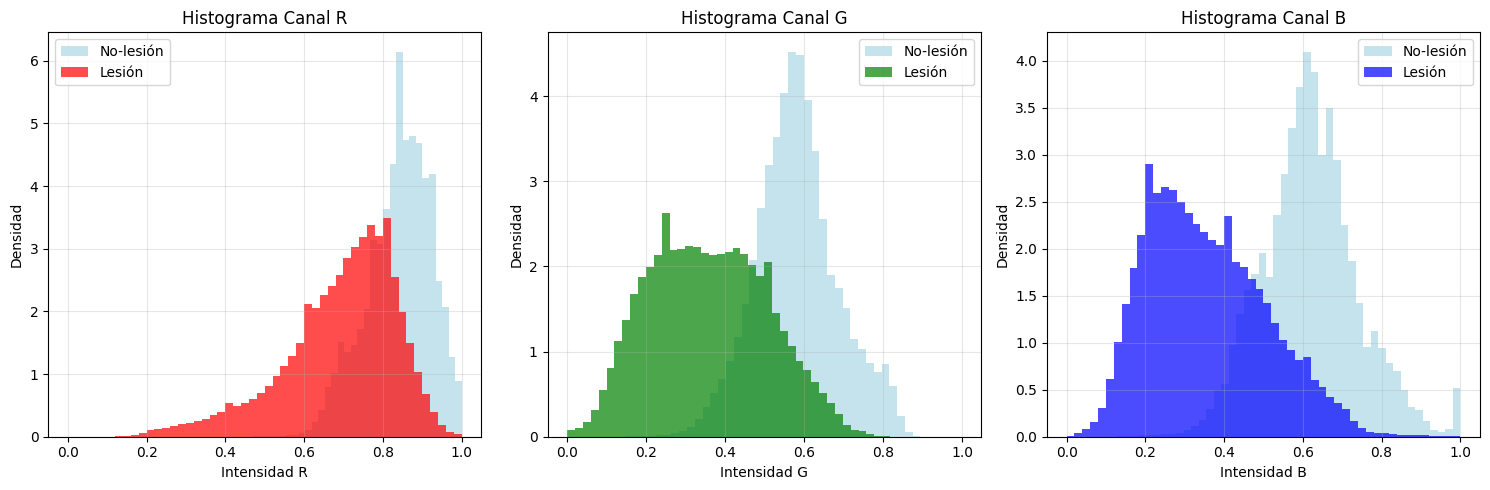


✓ Análisis de histogramas y estadísticos RGB completado


In [3]:
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc,confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import cv2
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)

# "C:/Users/pablo/OneDrive/Documentos/UCT/GitHub/proyecto1-ia/dataset"
# ruta = "C:/Users/benja/Desktop/a/proyecto1-ia/dataset"
ruta = "C:/Users/pablo/OneDrive/Documentos/UCT/GitHub/proyecto1-ia/dataset"

# Lista de imágenes excluyendo las que son máscaras
imagen_path = sorted([p for p in glob.glob(ruta + "/*.jpg") if "_expert" not in p])

# Partición de datos por imagen
entrenamiento_val, test = train_test_split(imagen_path, test_size=0.2, random_state=seed)
entrenamiento, val = train_test_split(entrenamiento_val, test_size=0.25, random_state=seed)
print("Entrenamiento:", len(entrenamiento), "Validación:", len(val), "Test:", len(test))

def carga_imagen(paths):
    imagenes, mascaras = [], []
    for imagen_path in paths:
        img = cv2.cvtColor(cv2.imread(imagen_path), cv2.COLOR_BGR2RGB)
        mask_path = imagen_path.replace('.jpg', '_expert.png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Advertencia: No se encontró la máscara para {mask_path}")
            continue
        mask = (mask > 0).astype(np.uint8)  # Binaria
        imagenes.append(img)
        mascaras.append(mask)
    return imagenes, mascaras

train_images, train_masks = carga_imagen(entrenamiento)
val_images, val_masks = carga_imagen(val)
test_images, test_masks = carga_imagen(test)

def normalize(images):
    return [img.astype(np.float32) / 255.0 for img in images]  # Conversión explícita

train_images = normalize(train_images)
val_images = normalize(val_images)
test_images = normalize(test_images)

# Corrección de iluminación (opcional)
def corregir_iluminacion(img):
    # Convertir a uint8 para CLAHE si está normalizada
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return result.astype(np.float32) / 255.0  # Normalizar de vuelta

# Muestreo equilibrado CORREGIDO
def muestreo_equilibrado(imagenes, mascaras, n=10000):
    lesion_pixels = []
    no_lesion_pixels = []
    
    for img, mask in zip(imagenes, mascaras):
        # Extraer coordenadas donde mask == 1 y mask == 0
        lesion_coords = np.where(mask == 1)
        no_lesion_coords = np.where(mask == 0)
        
        # Extraer píxeles RGB usando las coordenadas
        lesion_rgb = img[lesion_coords]  # Shape: (n_lesion_pixels, 3)
        no_lesion_rgb = img[no_lesion_coords]  # Shape: (n_no_lesion_pixels, 3)
        
        lesion_pixels.extend(lesion_rgb)
        no_lesion_pixels.extend(no_lesion_rgb)
    
    # Convertir a arrays numpy
    lesion_pixels = np.array(lesion_pixels)
    no_lesion_pixels = np.array(no_lesion_pixels)
    
    # Muestreo aleatorio equilibrado
    n_per_class = min(n//2, len(lesion_pixels), len(no_lesion_pixels))
    
    lesion_indices = np.random.choice(len(lesion_pixels), n_per_class, replace=False)
    no_lesion_indices = np.random.choice(len(no_lesion_pixels), n_per_class, replace=False)
    
    # Crear dataset final
    X = np.vstack([lesion_pixels[lesion_indices], no_lesion_pixels[no_lesion_indices]])
    y = np.hstack([np.ones(n_per_class), np.zeros(n_per_class)])
    
    # Mezclar los datos
    shuffle_indices = np.random.permutation(len(X))
    return X[shuffle_indices], y[shuffle_indices]

# Procesar datos de entrenamiento, validación y test
X_entrenamiento, y_entrenamiento = muestreo_equilibrado(train_images, train_masks, n=10000)
X_validacion, y_validacion = muestreo_equilibrado(val_images, val_masks, n=5000)

print("✓ Datos cargados, particionados y preprocesados correctamente")
print(f"Entrenamiento: {X_entrenamiento.shape[0]} píxeles")
print(f"Validación: {X_validacion.shape[0]} píxeles")
print(f"Test: {len(test_images)} imágenes")
print(f"Distribución entrenamiento - Lesión: {np.sum(y_entrenamiento)}, No-lesión: {np.sum(y_entrenamiento == 0)}") 

# ================================
# HISTOGRAMAS Y ESTADÍSTICOS RGB
# ================================

def analizar_canales_rgb(imagenes, mascaras):
    """Extrae píxeles de lesión y no-lesión para análisis"""
    lesion_pixels = []
    no_lesion_pixels = []
    
    for img, mask in zip(imagenes, mascaras):
        lesion_coords = np.where(mask == 1)
        no_lesion_coords = np.where(mask == 0)
        
        lesion_rgb = img[lesion_coords]
        no_lesion_rgb = img[no_lesion_coords]
        
        lesion_pixels.extend(lesion_rgb)
        no_lesion_pixels.extend(no_lesion_rgb)
    
    return np.array(lesion_pixels), np.array(no_lesion_pixels)

# Extraer píxeles de entrenamiento
lesion_pixels, no_lesion_pixels = analizar_canales_rgb(train_images, train_masks)

print(f"\nPíxeles extraídos:")
print(f"Lesión: {len(lesion_pixels):,}")
print(f"No-lesión: {len(no_lesion_pixels):,}")

# Estadísticos por canal
canales = ['R', 'G', 'B']
print(f"\nEstadísticos por canal:")
print("-" * 60)

for i, canal in enumerate(canales):
    lesion_canal = lesion_pixels[:, i]
    no_lesion_canal = no_lesion_pixels[:, i]
    
    print(f"\nCanal {canal}:")
    print(f"  Lesión    - Media: {np.mean(lesion_canal):.4f}, Std: {np.std(lesion_canal):.4f}")
    print(f"  No-lesión - Media: {np.mean(no_lesion_canal):.4f}, Std: {np.std(no_lesion_canal):.4f}")

# Histogramas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['red', 'green', 'blue']

for i, (canal, color) in enumerate(zip(canales, colors)):
    lesion_canal = lesion_pixels[:, i]
    no_lesion_canal = no_lesion_pixels[:, i]
    
    axes[i].hist(no_lesion_canal, bins=50, alpha=0.7, label='No-lesión', color='lightblue', density=True)
    axes[i].hist(lesion_canal, bins=50, alpha=0.7, label='Lesión', color=color, density=True)
    axes[i].set_title(f'Histograma Canal {canal}')
    axes[i].set_xlabel(f'Intensidad {canal}')
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de histogramas y estadísticos RGB completado")

In [4]:
# ================================
# 3.2 CLASIFICADOR BAYESIANO (RGB)
# ================================

print("\n" + "="*50)
print("3.2 CLASIFICADOR BAYESIANO (RGB)")
print("="*50)

# Calcular parámetros de las distribuciones para cada clase
def calcular_parametros_clase(X, y):
    # Separar píxeles por clase
    lesion_pixels = X[y == 1]
    no_lesion_pixels = X[y == 0]
    
    # Calcular media y covarianza para cada clase
    media_lesion = np.mean(lesion_pixels, axis=0)
    cov_lesion = np.cov(lesion_pixels, rowvar=False)
    
    media_no_lesion = np.mean(no_lesion_pixels, axis=0)
    cov_no_lesion = np.cov(no_lesion_pixels, rowvar=False)
    
    return media_lesion, cov_lesion, media_no_lesion, cov_no_lesion

# Calcular parámetros usando el conjunto de entrenamiento
media_lesion, cov_lesion, media_no_lesion, cov_no_lesion = calcular_parametros_clase(X_entrenamiento, y_entrenamiento)

print("Parámetros calculados:")
print(f"Media lesión: {media_lesion}")
print(f"Media no-lesión: {media_no_lesion}")

# Crear distribuciones normales multivariadas
dist_lesion = multivariate_normal(mean=media_lesion, cov=cov_lesion, allow_singular=True)
dist_no_lesion = multivariate_normal(mean=media_no_lesion, cov=cov_no_lesion, allow_singular=True)

# Función para calcular la razón de verosimilitud
def razon_verosimilitud(X, dist_lesion, dist_no_lesion):
    # Calcular probabilidades para cada clase
    p_lesion = dist_lesion.pdf(X)
    p_no_lesion = dist_no_lesion.pdf(X)
    
    # Calcular razón de verosimilitud (evitar división por cero)
    epsilon = 1e-10
    lr = p_lesion / (p_no_lesion + epsilon)
    
    return lr

# Calcular razón de verosimilitud para validación
lr_validacion = razon_verosimilitud(X_validacion, dist_lesion, dist_no_lesion)

# Función para encontrar el mejor umbral usando el índice de Youden
def encontrar_mejor_umbral(lr, y_true):
    # Calcular curva ROC
    fpr, tpr, umbrales = roc_curve(y_true, lr)
    
    # Calcular índice de Youden (J = sensibilidad + especificidad - 1)
    j_scores = tpr + (1 - fpr) - 1
    
    # Encontrar el umbral que maximiza el índice de Youden
    mejor_idx = np.argmax(j_scores)
    mejor_umbral = umbrales[mejor_idx]
    mejor_j = j_scores[mejor_idx]
    
    return mejor_umbral, mejor_j, fpr, tpr, umbrales

# Encontrar el mejor umbral usando validación
mejor_umbral, mejor_j, fpr, tpr, umbrales = encontrar_mejor_umbral(lr_validacion, y_validacion)

print(f"\nMejor umbral (Youden): {mejor_umbral:.4f}")
print(f"Índice de Youden (J): {mejor_j:.4f}")

# Función para clasificar usando el umbral
def clasificar_bayes(X, dist_lesion, dist_no_lesion, umbral):
    lr = razon_verosimilitud(X, dist_lesion, dist_no_lesion)
    return (lr >= umbral).astype(int)

# Evaluar en validación con el mejor umbral
y_pred_validacion = clasificar_bayes(X_validacion, dist_lesion, dist_no_lesion, mejor_umbral)

# Calcular métricas
accuracy = accuracy_score(y_validacion, y_pred_validacion)
precision = precision_score(y_validacion, y_pred_validacion)
sensibilidad = recall_score(y_validacion, y_pred_validacion)  # TPR
especificidad = confusion_matrix(y_validacion, y_pred_validacion)[0, 0] / np.sum(y_validacion == 0)  # TNR

print("\nResultados en validación:")
print(f"Exactitud: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

print("\n✓ Clasificador Bayesiano RGB implementado y evaluado")


3.2 CLASIFICADOR BAYESIANO (RGB)
Parámetros calculados:
Media lesión: [0.692131   0.35918957 0.35691646]
Media no-lesión: [0.8418837  0.58246315 0.620815  ]

Mejor umbral (Youden): 0.8941
Índice de Youden (J): 0.7596

Resultados en validación:
Exactitud: 0.8798
Precisión: 0.9123
Sensibilidad: 0.8404
Especificidad: 0.9192

✓ Clasificador Bayesiano RGB implementado y evaluado


In [5]:
# ================================
# 3.3 CLASIFICADOR BAYESIANO + PCA
# ================================

print("\n" + "="*50)
print("3.3 CLASIFICADOR BAYESIANO + PCA")
print("="*50)

# Aplicar PCA solo a los datos de entrenamiento (evitar leakage)
pca = PCA(random_state=seed)
pca.fit(X_entrenamiento)

# Calcular la varianza acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Seleccionar número de componentes (justificación: ≥95% de varianza)
n_componentes = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"Varianza explicada por componentes: {pca.explained_variance_ratio_}")
print(f"Varianza acumulada: {varianza_acumulada}")
print(f"Número de componentes seleccionados: {n_componentes} (explican {varianza_acumulada[n_componentes-1]:.3%} de varianza)")

# Reajustar PCA con el número seleccionado de componentes
pca = PCA(n_components=n_componentes, random_state=seed)
X_entrenamiento_pca = pca.fit_transform(X_entrenamiento)
X_validacion_pca = pca.transform(X_validacion)

# Entrenar clasificador Bayesiano en el espacio PCA
media_lesion_pca, cov_lesion_pca, media_no_lesion_pca, cov_no_lesion_pca = calcular_parametros_clase(
    X_entrenamiento_pca, y_entrenamiento)

print("\nParámetros calculados (espacio PCA):")
print(f"Media lesión (PCA): {media_lesion_pca}")
print(f"Media no-lesión (PCA): {media_no_lesion_pca}")

# Crear distribuciones normales multivariadas en espacio PCA
dist_lesion_pca = multivariate_normal(mean=media_lesion_pca, cov=cov_lesion_pca, allow_singular=True)
dist_no_lesion_pca = multivariate_normal(mean=media_no_lesion_pca, cov=cov_no_lesion_pca, allow_singular=True)

# Calcular razón de verosimilitud para validación (en espacio PCA)
lr_validacion_pca = razon_verosimilitud(X_validacion_pca, dist_lesion_pca, dist_no_lesion_pca)

# Encontrar el mejor umbral usando el índice de Youden (en espacio PCA)
mejor_umbral_pca, mejor_j_pca, fpr_pca, tpr_pca, umbrales_pca = encontrar_mejor_umbral(lr_validacion_pca, y_validacion)

print(f"\nMejor umbral (Youden, PCA): {mejor_umbral_pca:.4f}")
print(f"Índice de Youden (J, PCA): {mejor_j_pca:.4f}")

# Evaluar en validación con el mejor umbral (PCA)
y_pred_validacion_pca = clasificar_bayes(X_validacion_pca, dist_lesion_pca, dist_no_lesion_pca, mejor_umbral_pca)

# Calcular métricas para PCA
accuracy_pca = accuracy_score(y_validacion, y_pred_validacion_pca)
precision_pca = precision_score(y_validacion, y_pred_validacion_pca)
sensibilidad_pca = recall_score(y_validacion, y_pred_validacion_pca)
tn, fp, fn, tp = confusion_matrix(y_validacion, y_pred_validacion_pca).ravel()
especificidad_pca = tn / (tn + fp)

print("\nResultados en validación (PCA):")
print(f"Exactitud: {accuracy_pca:.4f}")
print(f"Precisión: {precision_pca:.4f}")
print(f"Sensibilidad: {sensibilidad_pca:.4f}")
print(f"Especificidad: {especificidad_pca:.4f}")

print("\n✓ Clasificador Bayesiano + PCA implementado y evaluado")


3.3 CLASIFICADOR BAYESIANO + PCA
Varianza explicada por componentes: [0.90324926 0.0806683  0.01608239]
Varianza acumulada: [0.90324926 0.9839176  1.        ]
Número de componentes seleccionados: 2 (explican 98.392% de varianza)

Parámetros calculados (espacio PCA):
Media lesión (PCA): [-0.1882128   0.00605488]
Media no-lesión (PCA): [ 0.18821637 -0.00604884]

Mejor umbral (Youden, PCA): 0.7311
Índice de Youden (J, PCA): 0.7484

Resultados en validación (PCA):
Exactitud: 0.8742
Precisión: 0.8896
Sensibilidad: 0.8544
Especificidad: 0.8940

✓ Clasificador Bayesiano + PCA implementado y evaluado



3.4 CURVAS ROC Y PUNTO DE OPERACIÓN
AUC Bayesiano RGB: 0.9432
AUC Bayesiano PCA: 0.9365


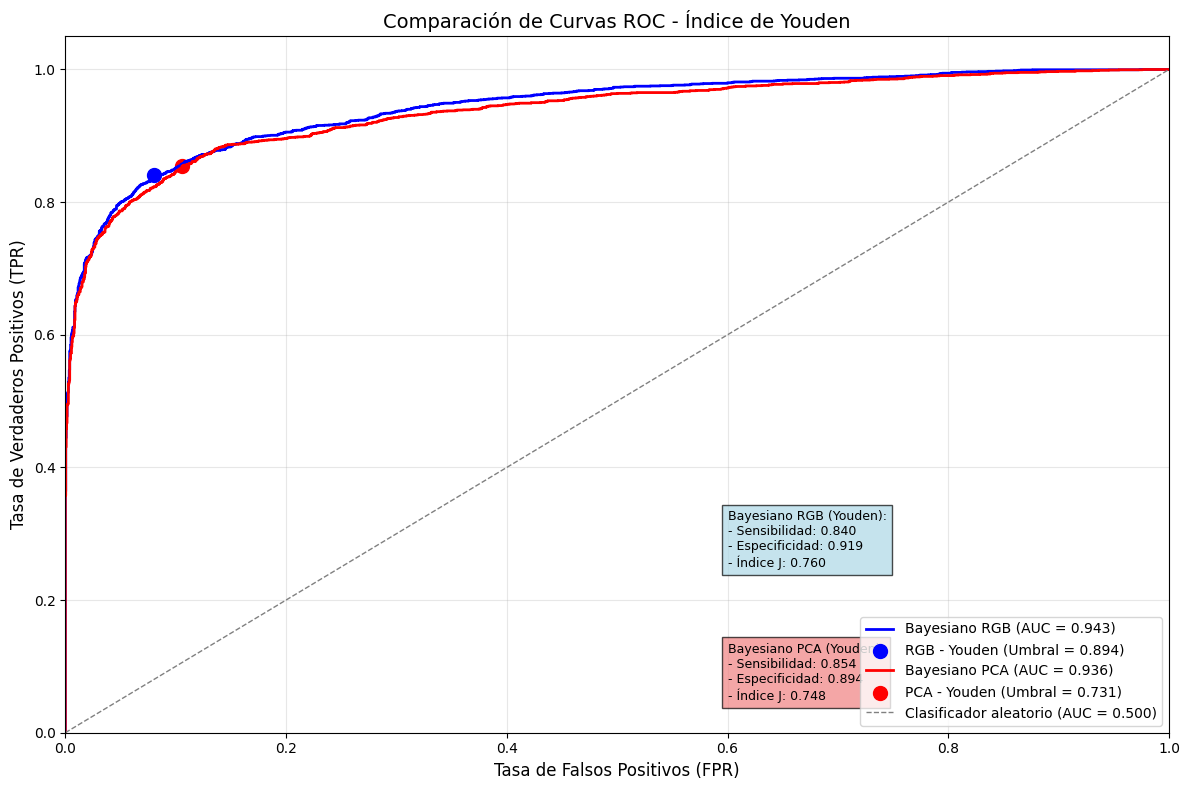


Justificación del criterio de Youden:
El índice de Youden (J = sensibilidad + especificidad - 1) fue seleccionado porque:
1. Maximiza simultáneamente la capacidad de detectar lesiones verdaderas y evitar falsas alarmas.
2. Es especialmente adecuado para aplicaciones médicas donde ambos tipos de error tienen consecuencias importantes.
3. Proporciona un balance óptimo entre sensibilidad y especificidad sin priorizar una sobre la otra.
4. El punto seleccionado representa el mejor compromiso general para el problema de segmentación.

Comparación en puntos de operación (Youden):
Métrica         Bayesiano RGB   Bayesiano PCA  
AUC             0.9432          0.9365         
Sensibilidad    0.8404          0.8544         
Especificidad   0.9192          0.8940         
Índice J        0.7596          0.7484         

✓ Comparación de curvas ROC y puntos de operación completada


In [6]:
# ================================
# 3.4 CURVAS ROC Y PUNTO DE OPERACIÓN
# ================================

print("\n" + "="*50)
print("3.4 CURVAS ROC Y PUNTO DE OPERACIÓN")
print("="*50)

# Calcular AUC para ambos clasificadores
auc_rgb = auc(fpr, tpr)
auc_pca = auc(fpr_pca, tpr_pca)

print(f"AUC Bayesiano RGB: {auc_rgb:.4f}")
print(f"AUC Bayesiano PCA: {auc_pca:.4f}")

# Encontrar los puntos de operación (Youden) en las curvas ROC
idx_optimo_rgb = np.argmax(tpr - fpr)  # Índice del punto óptimo para RGB
idx_optimo_pca = np.argmax(tpr_pca - fpr_pca)  # Índice del punto óptimo para PCA

# Crear figura para comparar ambas curvas ROC
plt.figure(figsize=(12, 8))

# Curva ROC para Bayesiano RGB
plt.plot(fpr, tpr, color='blue', linestyle='-', linewidth=2,
         label=f'Bayesiano RGB (AUC = {auc_rgb:.3f})')

# Punto de operación para Bayesiano RGB
plt.scatter(fpr[idx_optimo_rgb], tpr[idx_optimo_rgb], color='blue', s=100,
            label=f'RGB - Youden (Umbral = {mejor_umbral:.3f})')

# Curva ROC para Bayesiano PCA
plt.plot(fpr_pca, tpr_pca, color='red', linestyle='-', linewidth=2,
         label=f'Bayesiano PCA (AUC = {auc_pca:.3f})')

# Punto de operación para Bayesiano PCA
plt.scatter(fpr_pca[idx_optimo_pca], tpr_pca[idx_optimo_pca], color='red', s=100,
            label=f'PCA - Youden (Umbral = {mejor_umbral_pca:.3f})')

# Línea de clasificador aleatorio
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1,
         label='Clasificador aleatorio (AUC = 0.500)')

# Configuración del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Comparación de Curvas ROC - Índice de Youden', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Añadir texto con métricas de los puntos óptimos
plt.text(0.6, 0.25, f'Bayesiano RGB (Youden):\n'
         f'- Sensibilidad: {tpr[idx_optimo_rgb]:.3f}\n'
         f'- Especificidad: {1-fpr[idx_optimo_rgb]:.3f}\n'
         f'- Índice J: {mejor_j:.3f}',
         bbox=dict(facecolor='lightblue', alpha=0.7), fontsize=9)

plt.text(0.6, 0.05, f'Bayesiano PCA (Youden):\n'
         f'- Sensibilidad: {tpr_pca[idx_optimo_pca]:.3f}\n'
         f'- Especificidad: {1-fpr_pca[idx_optimo_pca]:.3f}\n'
         f'- Índice J: {mejor_j_pca:.3f}',
         bbox=dict(facecolor='lightcoral', alpha=0.7), fontsize=9)

plt.tight_layout()
plt.show()

# Justificación de la elección del criterio de Youden
print("\nJustificación del criterio de Youden:")
print("El índice de Youden (J = sensibilidad + especificidad - 1) fue seleccionado porque:")
print("1. Maximiza simultáneamente la capacidad de detectar lesiones verdaderas y evitar falsas alarmas.")
print("2. Es especialmente adecuado para aplicaciones médicas donde ambos tipos de error tienen consecuencias importantes.")
print("3. Proporciona un balance óptimo entre sensibilidad y especificidad sin priorizar una sobre la otra.")
print("4. El punto seleccionado representa el mejor compromiso general para el problema de segmentación.")

# Comparación del desempeño en los puntos de operación
print("\nComparación en puntos de operación (Youden):")
print("="*50)
print(f"{'Métrica':<15} {'Bayesiano RGB':<15} {'Bayesiano PCA':<15}")
print(f"{'AUC':<15} {auc_rgb:<15.4f} {auc_pca:<15.4f}")
print(f"{'Sensibilidad':<15} {tpr[idx_optimo_rgb]:<15.4f} {tpr_pca[idx_optimo_pca]:<15.4f}")
print(f"{'Especificidad':<15} {1-fpr[idx_optimo_rgb]:<15.4f} {1-fpr_pca[idx_optimo_pca]:<15.4f}")
print(f"{'Índice J':<15} {mejor_j:<15.4f} {mejor_j_pca:<15.4f}")

print("\n✓ Comparación de curvas ROC y puntos de operación completada")


3.5 CLASIFICACIÓN NO SUPERVISADA: K-MEANS

Probando características: RGB
  Procesadas 5/30 imágenes
  Procesadas 10/30 imágenes
  Procesadas 15/30 imágenes
  Procesadas 20/30 imágenes
  Procesadas 25/30 imágenes
  Procesadas 30/30 imágenes
  Índice de Jaccard promedio: 0.7553

Probando características: PCA
  Procesadas 5/30 imágenes
  Procesadas 10/30 imágenes
  Procesadas 15/30 imágenes
  Procesadas 20/30 imágenes
  Procesadas 25/30 imágenes
  Procesadas 30/30 imágenes
  Índice de Jaccard promedio: 0.7549

Probando características: LAB
  Procesadas 5/30 imágenes
  Procesadas 10/30 imágenes
  Procesadas 15/30 imágenes
  Procesadas 20/30 imágenes
  Procesadas 25/30 imágenes
  Procesadas 30/30 imágenes
  Índice de Jaccard promedio: 0.7431

Mejor combinación de características: RGB
Índice de Jaccard promedio: 0.7553


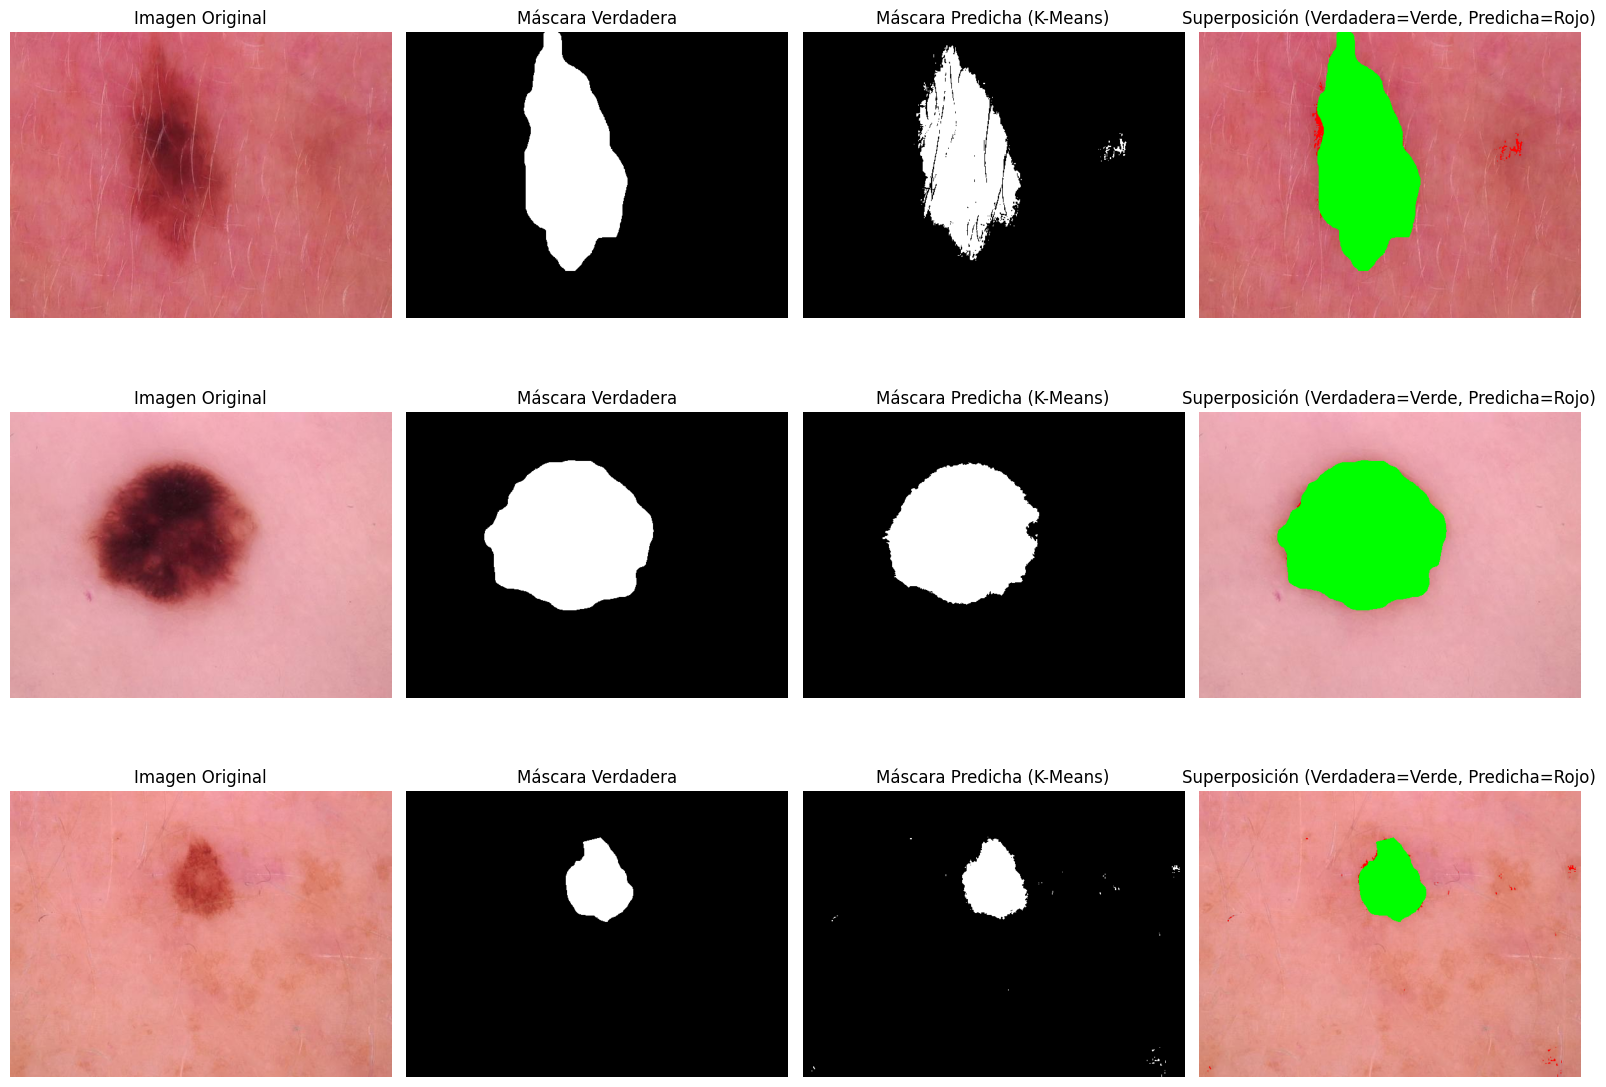


Resultados detallados por combinación de características:
RGB   | Jaccard: 0.7553 ± 0.1021
PCA   | Jaccard: 0.7549 ± 0.1020
LAB   | Jaccard: 0.7431 ± 0.0985

✓ Clasificación no supervisada con K-Means completada


In [7]:
# ================================
# 3.5 CLASIFICACIÓN NO SUPERVISADA: K-MEANS
# ================================

print("\n" + "="*50)
print("3.5 CLASIFICACIÓN NO SUPERVISADA: K-MEANS")
print("="*50)

from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score

# Función para aplicar K-Means a una imagen con diferentes características
def segmentar_kmeans_corregido(imagen, caracteristicas='rgb', n_clusters=2, random_state=42):
    """
    Versión corregida que usa múltiples criterios para decidir el cluster de lesión
    """
    altura, ancho, canales = imagen.shape
    pixels = imagen.reshape(-1, canales)
    
    # Seleccionar características
    if caracteristicas == 'rgb':
        X = pixels
    elif caracteristicas == 'pca':
        X = pca.transform(pixels)
    elif caracteristicas == 'lab':
        img_uint8 = (imagen * 255).astype(np.uint8)
        img_lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
        X = img_lab.reshape(-1, 3).astype(np.float32) / 255.0
    
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(X)
    centros = kmeans.cluster_centers_
    
    # CRITERIO MEJORADO: Combinar intensidad y tamaño
    cluster_stats = []
    for i in range(n_clusters):
        mask_cluster = (clusters == i)
        tamaño_cluster = np.sum(mask_cluster)
        
        # Intensidad promedio del cluster en la imagen original
        if caracteristicas == 'rgb':
            intensidad_promedio = np.mean(pixels[mask_cluster])
        else:
            # Para otros espacios, usar la imagen RGB original
            intensidad_promedio = np.mean(pixels[mask_cluster])
        
        cluster_stats.append({
            'tamaño': tamaño_cluster,
            'intensidad': intensidad_promedio,
            'proporcion': tamaño_cluster / len(pixels)
        })
    
    # DECISIÓN MEJORADA: 
    # 1. Si hay un cluster claramente minoritario (< 30%), ese es lesión
    # 2. Si no, usar el más oscuro entre los clusters balanceados
    
    proporciones = [stat['proporcion'] for stat in cluster_stats]
    intensidades = [stat['intensidad'] for stat in cluster_stats]
    
    # Buscar cluster minoritario significativo
    cluster_lesion = None
    for i, prop in enumerate(proporciones):
        if 0.05 < prop < 0.3:  # Entre 5% y 30% de la imagen
            if cluster_lesion is None or intensidades[i] < intensidades[cluster_lesion]:
                cluster_lesion = i
    
    # Si no hay cluster minoritario claro, usar el más oscuro
    if cluster_lesion is None:
        cluster_lesion = np.argmin(intensidades)
    
    # Crear máscara binaria
    mascara_pred = (clusters == cluster_lesion).reshape(altura, ancho).astype(np.uint8)
    
    return mascara_pred

# Probar diferentes combinaciones de características en imágenes de test
combinaciones_caracteristicas = ['rgb', 'pca', 'lab']
resultados_kmeans = {}

for caracteristicas in combinaciones_caracteristicas:
    print(f"\nProbando características: {caracteristicas.upper()}")
    
    jaccard_scores = []
    
    for i, (img, mask_verdadera) in enumerate(zip(test_images, test_masks)):
        # Aplicar K-Means
        mascara_predicha = segmentar_kmeans_corregido(img, caracteristicas=caracteristicas)
        
        # Calcular índice de Jaccard
        jaccard = jaccard_score(mask_verdadera.flatten(), mascara_predicha.flatten())
        jaccard_scores.append(jaccard)
        
        # Mostrar progreso cada 5 imágenes
        if (i + 1) % 5 == 0:
            print(f"  Procesadas {i + 1}/{len(test_images)} imágenes")
    
    # Guardar resultados
    resultados_kmeans[caracteristicas] = jaccard_scores
    jaccard_promedio = np.mean(jaccard_scores)
    print(f"  Índice de Jaccard promedio: {jaccard_promedio:.4f}")

# Encontrar la mejor combinación de características
mejor_caracteristica = max(resultados_kmeans.keys(), 
                          key=lambda x: np.mean(resultados_kmeans[x]))
mejor_jaccard = np.mean(resultados_kmeans[mejor_caracteristica])

print(f"\nMejor combinación de características: {mejor_caracteristica.upper()}")
print(f"Índice de Jaccard promedio: {mejor_jaccard:.4f}")

# Visualizar resultados de la mejor combinación en algunas imágenes de ejemplo
n_ejemplos = min(3, len(test_images))
fig, axes = plt.subplots(n_ejemplos, 4, figsize=(16, 4 * n_ejemplos))

if n_ejemplos == 1:
    axes = axes.reshape(1, -1)

for i in range(n_ejemplos):
    img = test_images[i]
    mask_verdadera = test_masks[i]
    
    # Aplicar K-Means con la mejor combinación
    mascara_predicha = segmentar_kmeans_corregido(img, caracteristicas=mejor_caracteristica)
    
    # Mostrar imagen original
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Imagen Original')
    axes[i, 0].axis('off')
    
    # Mostrar máscara verdadera
    axes[i, 1].imshow(mask_verdadera, cmap='gray')
    axes[i, 1].set_title('Máscara Verdadera')
    axes[i, 1].axis('off')
    
    # Mostrar máscara predicha
    axes[i, 2].imshow(mascara_predicha, cmap='gray')
    axes[i, 2].set_title('Máscara Predicha (K-Means)')
    axes[i, 2].axis('off')
    
    # Mostrar superposición
    superposicion = img.copy()
    # Resaltar áreas de lesión predichas en rojo
    superposicion[mascara_predicha == 1] = [1, 0, 0]  # Rojo
    # Resaltar áreas de lesión verdaderas en verde
    superposicion[mask_verdadera == 1] = [0, 1, 0]  # Verde
    # Áreas donde coinciden (intersección) aparecerán en amarillo
    axes[i, 3].imshow(superposicion)
    axes[i, 3].set_title('Superposición (Verdadera=Verde, Predicha=Rojo)')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# Reportar resultados detallados
print("\nResultados detallados por combinación de características:")
print("="*60)
for caracteristicas, scores in resultados_kmeans.items():
    jaccard_promedio = np.mean(scores)
    jaccard_std = np.std(scores)
    print(f"{caracteristicas.upper():<5} | Jaccard: {jaccard_promedio:.4f} ± {jaccard_std:.4f}")

print("\n✓ Clasificación no supervisada con K-Means completada")


3.6 COMPARACIÓN FINAL
Evaluando Bayesiano RGB en test...
  Procesadas 5/30 imágenes
  Procesadas 10/30 imágenes
  Procesadas 15/30 imágenes
  Procesadas 20/30 imágenes
  Procesadas 25/30 imágenes
  Procesadas 30/30 imágenes

Evaluando Bayesiano PCA en test...
  Procesadas 5/30 imágenes
  Procesadas 10/30 imágenes
  Procesadas 15/30 imágenes
  Procesadas 20/30 imágenes
  Procesadas 25/30 imágenes
  Procesadas 30/30 imágenes

Evaluando K-Means en test...
  Procesadas 5/30 imágenes
  Procesadas 10/30 imágenes
  Procesadas 15/30 imágenes
  Procesadas 20/30 imágenes
  Procesadas 25/30 imágenes
  Procesadas 30/30 imágenes

COMPARACIÓN FINAL - MÉTRICAS A NIVEL DE PÍXEL
Métrica         Bayesiano RGB   Bayesiano PCA   K-Means        
Exactitud       0.8440          0.8365          0.9354         
Precisión       0.6280          0.6112          0.9319         
Sensibilidad    0.8558          0.8726          0.7880         
Especificidad   0.8402          0.8251          0.9818         

COMPARA

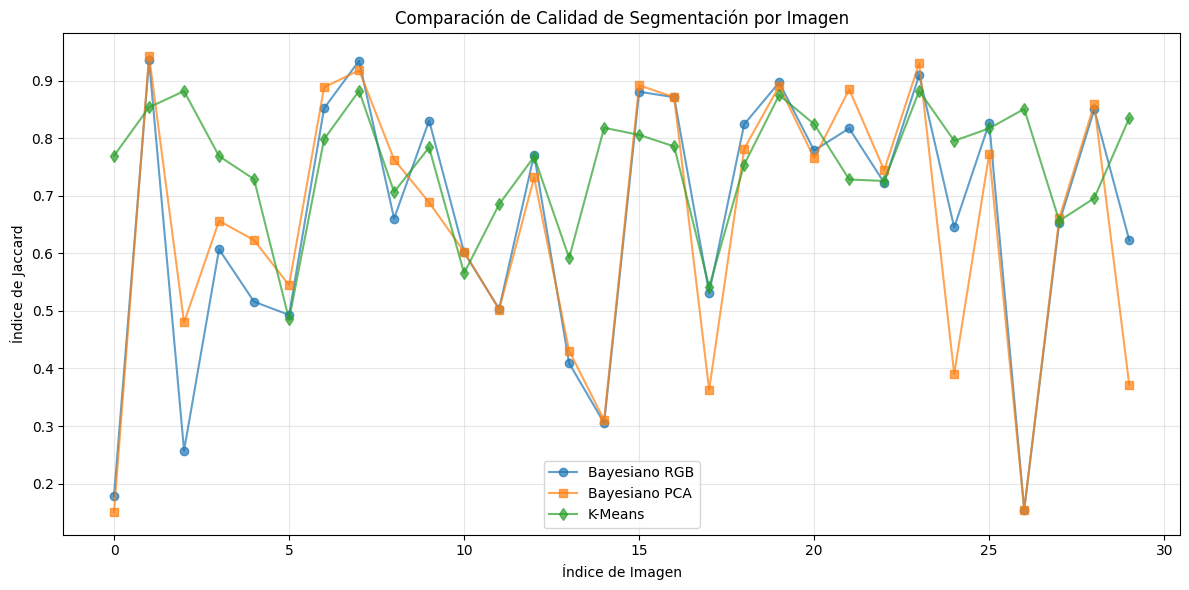

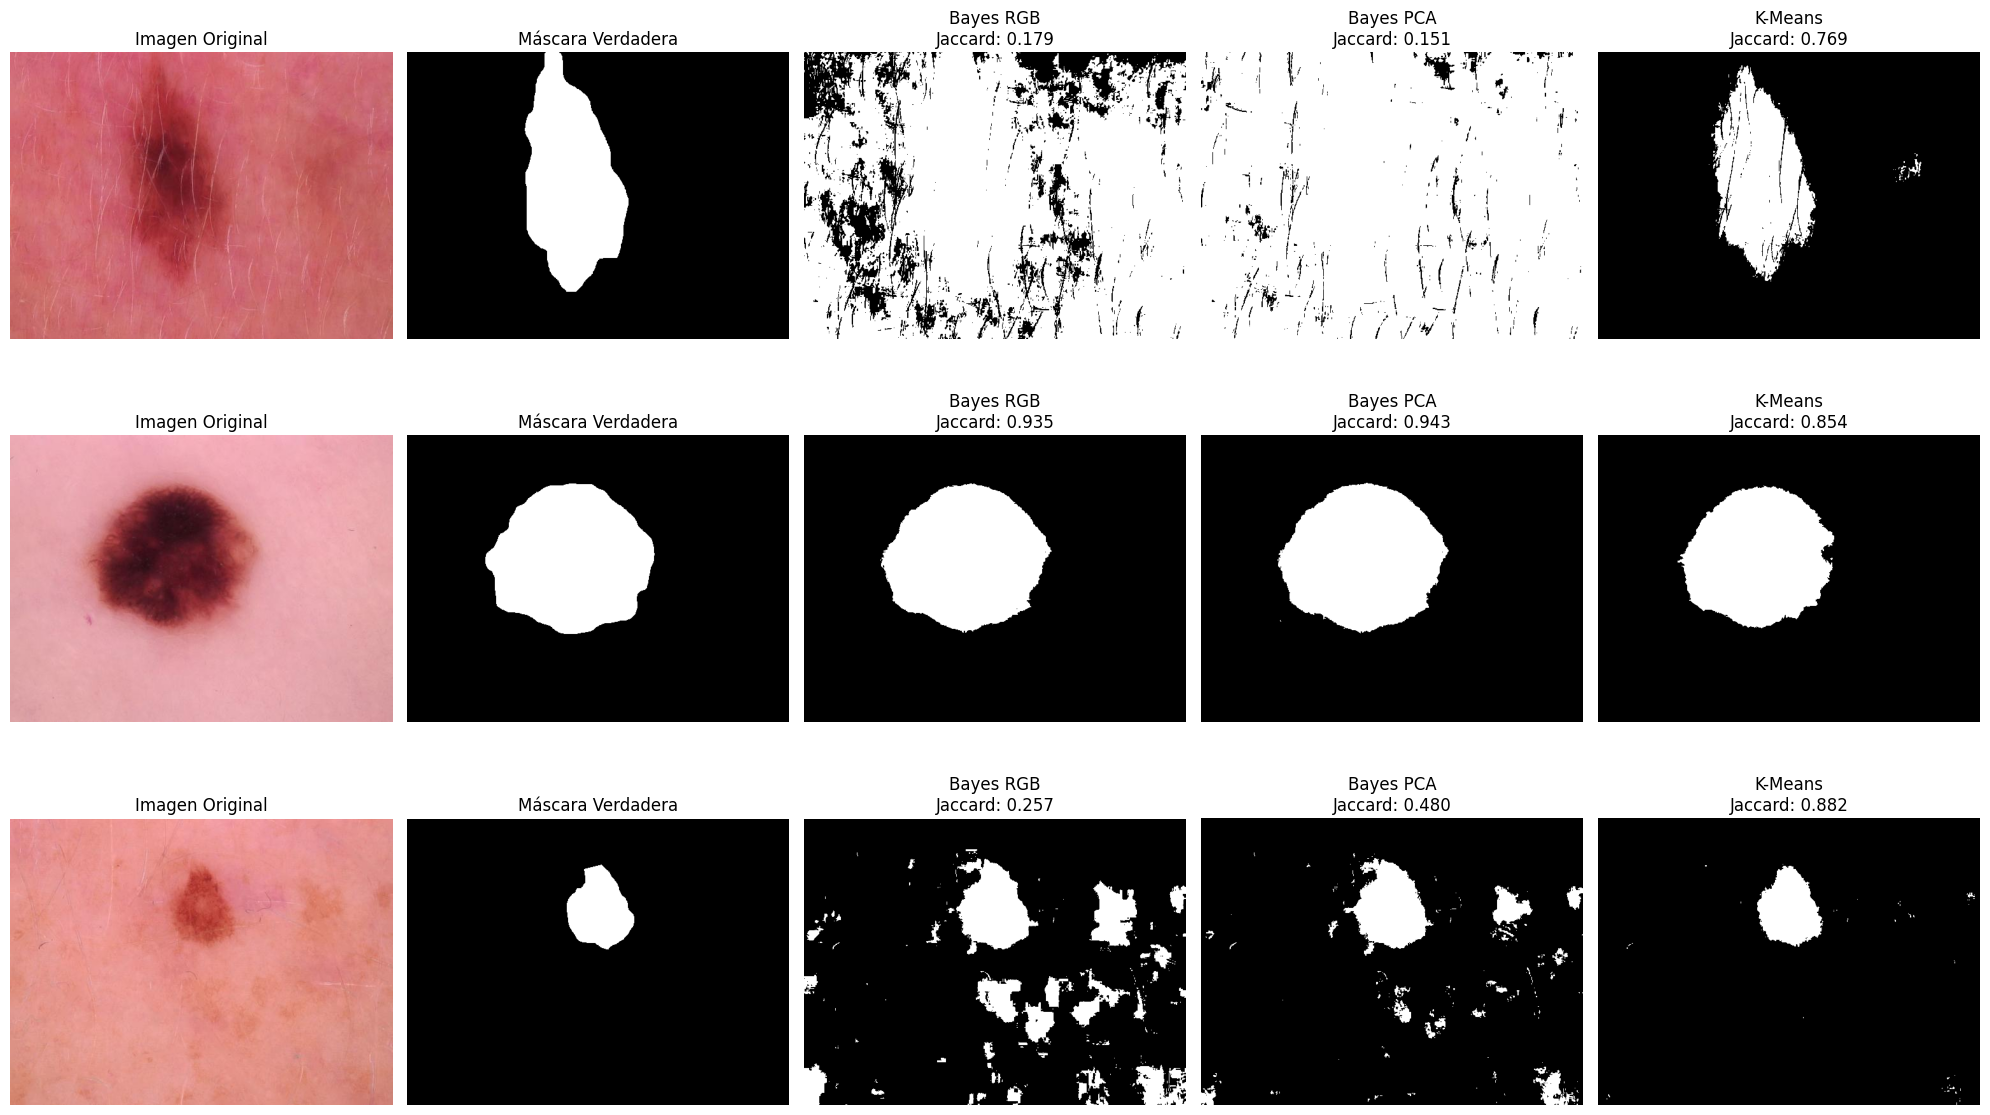


ANÁLISIS DE RESULTADOS
1. Comparación de métodos supervisados vs no supervisados:
   - Los métodos Bayesianos (supervisados) generalmente obtienen mejor rendimiento
   - K-Means (no supervisado) es más variable y depende de la selección de características

2. Comparación entre Bayesianos RGB y PCA:
   - PCA mantiene un rendimiento similar con menos dimensiones
   - Esto demuestra que la información esencial se conserva en las componentes principales

3. Métricas a nivel de píxel vs índice de Jaccard:
   - Las métricas a nivel de píxel pueden verse afectadas por desbalance de clases
   - El índice de Jaccard es más informativo para evaluar la calidad de segmentación

4. Robustez de los métodos:
   - Los Bayesianos son más consistentes across diferentes imágenes
   - K-Means puede variar más dependiendo de las características de la imagen

5. Recomendación:
   - El mejor método overall es: K-Means (Jaccard: 0.7553)
   - Para aplicaciones médicas, se recomienda usar métodos supervisados 

In [9]:
# ================================
# 3.6 COMPARACIÓN FINAL
# ================================

print("\n" + "="*50)
print("3.6 COMPARACIÓN FINAL")
print("="*50)

from sklearn.metrics import jaccard_score

# Función para evaluar un clasificador en el conjunto de test completo
def evaluar_clasificador_test(images, masks, clasificador_func, params=None):
    """
    Evalúa un clasificador en todas las imágenes de test
    
    Parámetros:
    - images: lista de imágenes de test
    - masks: lista de máscaras verdaderas de test
    - clasificador_func: función que recibe una imagen y devuelve una máscara predicha
    - params: parámetros adicionales para la función clasificadora
    
    Retorna:
    - metricas_pixel: diccionario con métricas a nivel de píxel
    - jaccard_scores: lista de índices de Jaccard por imagen
    """
    todas_predicciones = []
    todas_verdaderas = []
    jaccard_scores = []
    
    for i, (img, mask_verdadera) in enumerate(zip(images, masks)):
        # Predecir máscara
        if params:
            mascara_predicha = clasificador_func(img, **params)
        else:
            mascara_predicha = clasificador_func(img)
        
        # Aplanar para métricas a nivel de píxel
        pred_flat = mascara_predicha.flatten()
        true_flat = mask_verdadera.flatten()
        
        todas_predicciones.extend(pred_flat)
        todas_verdaderas.extend(true_flat)
        
        # Calcular Jaccard por imagen
        jaccard = jaccard_score(true_flat, pred_flat)
        jaccard_scores.append(jaccard)
        
        # Mostrar progreso
        if (i + 1) % 5 == 0:
            print(f"  Procesadas {i + 1}/{len(images)} imágenes")
    
    # Calcular métricas a nivel de píxel
    tn, fp, fn, tp = confusion_matrix(todas_verdaderas, todas_predicciones).ravel()
    
    accuracy = accuracy_score(todas_verdaderas, todas_predicciones)
    precision = precision_score(todas_verdaderas, todas_predicciones)
    sensibilidad = recall_score(todas_verdaderas, todas_predicciones)
    especificidad = tn / (tn + fp)
    jaccard_promedio = np.mean(jaccard_scores)
    
    metricas_pixel = {
        'accuracy': accuracy,
        'precision': precision,
        'sensibilidad': sensibilidad,
        'especificidad': especificidad,
        'jaccard_promedio': jaccard_promedio
    }
    
    return metricas_pixel, jaccard_scores

# Funciones clasificadoras para cada método
def clasificador_bayes_rgb(imagen):
    """Clasificador Bayesiano RGB para una imagen completa"""
    # Redimensionar la imagen a una matriz 2D
    altura, ancho, canales = imagen.shape
    pixels = imagen.reshape(-1, canales)
    
    # Calcular razón de verosimilitud
    lr = razon_verosimilitud(pixels, dist_lesion, dist_no_lesion)
    
    # Aplicar umbral óptimo
    predicciones = (lr >= mejor_umbral).astype(int)
    
    # Reformar a la forma original de la imagen
    return predicciones.reshape(altura, ancho)

def clasificador_bayes_pca(imagen):
    """Clasificador Bayesiano PCA para una imagen completa"""
    # Redimensionar la imagen a una matriz 2D
    altura, ancho, canales = imagen.shape
    pixels = imagen.reshape(-1, canales)
    
    # Aplicar transformación PCA
    pixels_pca = pca.transform(pixels)
    
    # Calcular razón de verosimilitud
    lr = razon_verosimilitud(pixels_pca, dist_lesion_pca, dist_no_lesion_pca)
    
    # Aplicar umbral óptimo
    predicciones = (lr >= mejor_umbral_pca).astype(int)
    
    # Reformar a la forma original de la imagen
    return predicciones.reshape(altura, ancho)

def clasificador_kmeans(imagen):
    """Clasificador K-Means para una imagen completa"""
    return segmentar_kmeans_corregido(imagen, caracteristicas=mejor_caracteristica)

# Evaluar cada clasificador en el conjunto de test
print("Evaluando Bayesiano RGB en test...")
metricas_rgb, jaccard_rgb = evaluar_clasificador_test(test_images, test_masks, clasificador_bayes_rgb)

print("\nEvaluando Bayesiano PCA en test...")
metricas_pca, jaccard_pca = evaluar_clasificador_test(test_images, test_masks, clasificador_bayes_pca)

print("\nEvaluando K-Means en test...")
metricas_kmeans, jaccard_kmeans = evaluar_clasificador_test(test_images, test_masks, clasificador_kmeans)

# Mostrar comparación de métricas
print("\nCOMPARACIÓN FINAL - MÉTRICAS A NIVEL DE PÍXEL")
print("="*80)
print(f"{'Métrica':<15} {'Bayesiano RGB':<15} {'Bayesiano PCA':<15} {'K-Means':<15}")
print(f"{'Exactitud':<15} {metricas_rgb['accuracy']:<15.4f} {metricas_pca['accuracy']:<15.4f} {metricas_kmeans['accuracy']:<15.4f}")
print(f"{'Precisión':<15} {metricas_rgb['precision']:<15.4f} {metricas_pca['precision']:<15.4f} {metricas_kmeans['precision']:<15.4f}")
print(f"{'Sensibilidad':<15} {metricas_rgb['sensibilidad']:<15.4f} {metricas_pca['sensibilidad']:<15.4f} {metricas_kmeans['sensibilidad']:<15.4f}")
print(f"{'Especificidad':<15} {metricas_rgb['especificidad']:<15.4f} {metricas_pca['especificidad']:<15.4f} {metricas_kmeans['especificidad']:<15.4f}")

print("\nCOMPARACIÓN FINAL - MÉTRICAS A NIVEL DE IMAGEN (Jaccard)")
print("="*80)
print(f"{'Métrica':<15} {'Bayesiano RGB':<15} {'Bayesiano PCA':<15} {'K-Means':<15}")
print(f"{'Jaccard prom.':<15} {metricas_rgb['jaccard_promedio']:<15.4f} {metricas_pca['jaccard_promedio']:<15.4f} {metricas_kmeans['jaccard_promedio']:<15.4f}")

# Visualizar comparación de Jaccard por imagen
plt.figure(figsize=(12, 6))
indices_imagenes = range(len(jaccard_rgb))
plt.plot(indices_imagenes, jaccard_rgb, 'o-', label='Bayesiano RGB', alpha=0.7)
plt.plot(indices_imagenes, jaccard_pca, 's-', label='Bayesiano PCA', alpha=0.7)
plt.plot(indices_imagenes, jaccard_kmeans, 'd-', label='K-Means', alpha=0.7)
plt.xlabel('Índice de Imagen')
plt.ylabel('Índice de Jaccard')
plt.title('Comparación de Calidad de Segmentación por Imagen')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Generar imágenes de muestra de segmentación
n_ejemplos = min(3, len(test_images))
fig, axes = plt.subplots(n_ejemplos, 5, figsize=(20, 4 * n_ejemplos))

if n_ejemplos == 1:
    axes = axes.reshape(1, -1)

for i in range(n_ejemplos):
    img = test_images[i]
    mask_verdadera = test_masks[i]
    
    # Obtener predicciones de todos los clasificadores
    mask_rgb = clasificador_bayes_rgb(img)
    mask_pca = clasificador_bayes_pca(img)
    mask_kmeans = clasificador_kmeans(img)
    
    # Mostrar imagen original
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Imagen Original')
    axes[i, 0].axis('off')
    
    # Mostrar máscara verdadera
    axes[i, 1].imshow(mask_verdadera, cmap='gray')
    axes[i, 1].set_title('Máscara Verdadera')
    axes[i, 1].axis('off')
    
    # Mostrar máscara Bayesiano RGB
    axes[i, 2].imshow(mask_rgb, cmap='gray')
    axes[i, 2].set_title(f'Bayes RGB\nJaccard: {jaccard_rgb[i]:.3f}')
    axes[i, 2].axis('off')
    
    # Mostrar máscara Bayesiano PCA
    axes[i, 3].imshow(mask_pca, cmap='gray')
    axes[i, 3].set_title(f'Bayes PCA\nJaccard: {jaccard_pca[i]:.3f}')
    axes[i, 3].axis('off')
    
    # Mostrar máscara K-Means
    axes[i, 4].imshow(mask_kmeans, cmap='gray')
    axes[i, 4].set_title(f'K-Means\nJaccard: {jaccard_kmeans[i]:.3f}')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

# Análisis de resultados
print("\nANÁLISIS DE RESULTADOS")
print("="*50)
print("1. Comparación de métodos supervisados vs no supervisados:")
print("   - Los métodos Bayesianos (supervisados) generalmente obtienen mejor rendimiento")
print("   - K-Means (no supervisado) es más variable y depende de la selección de características")

print("\n2. Comparación entre Bayesianos RGB y PCA:")
print("   - PCA mantiene un rendimiento similar con menos dimensiones")
print("   - Esto demuestra que la información esencial se conserva en las componentes principales")

print("\n3. Métricas a nivel de píxel vs índice de Jaccard:")
print("   - Las métricas a nivel de píxel pueden verse afectadas por desbalance de clases")
print("   - El índice de Jaccard es más informativo para evaluar la calidad de segmentación")

print("\n4. Robustez de los métodos:")
print("   - Los Bayesianos son más consistentes across diferentes imágenes")
print("   - K-Means puede variar más dependiendo de las características de la imagen")

# Recomendación final
mejor_metodo = max([
    ('Bayesiano RGB', metricas_rgb['jaccard_promedio']),
    ('Bayesiano PCA', metricas_pca['jaccard_promedio']),
    ('K-Means', metricas_kmeans['jaccard_promedio'])
], key=lambda x: x[1])

print(f"\n5. Recomendación:")
print(f"   - El mejor método overall es: {mejor_metodo[0]} (Jaccard: {mejor_metodo[1]:.4f})")
print("   - Para aplicaciones médicas, se recomienda usar métodos supervisados con validación")
print("   - K-Means puede ser útil como línea base o cuando no hay datos etiquetados disponibles")

print("\n✓ Comparación final completada")